# **Individual Assingment**: Default Credit Cards Clients

A bank in you region want to build a model to predict credit card defaulters more accurately in order minimize money loss. For this task we have a set of data on default payments and demographic data to help us do our task. Data is comprised in the following CSV files:


**TRAINING**

**`train_customers.csv`**
 - `ID`: ID of each client
 - `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit
 - `SEX`: Gender (1=male, 2=female)
 - `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
 - `MARRIAGE`: Marital status (1=married, 2=single, 3=others)
 - `AGE`: Age in years
 
**`train_series.csv`**
 - `ID`: ID of each client
 - `MONTH`: The month to wich data is refering
 - `PAY`: Repayment status in the corresponding month (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
 - `BILL_AMT`: Amount of bill statement in the corresponding month (NT dollar)
 - `PAY_AMT`: Amount of previous payment in the corresponding month (NT dollar)
 
**`train_target.csv`**
 - `DEFAULT_JULY`: Default payment in July (1=yes, 0=no)
 
 
**TEST** (For PART 3)
 - **`test_data.csv`**
 
**SUBMISSION** (For PART 3)
 - **`submission_features.csv`**
 
**BACKUP**
 - **`train_data.csv`**

Load all data and answer the following questions

Libraries used for the development of this project

In [2]:
#Libraries for manipulating dataframes.
import pandas as pd
import numpy as np

#Libraries for graphical interface
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns

#Libraries for preprocessing data\
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix

#Libraries for modeling
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## **A. DATA ENGINEERING (3 points)**

### **Question 1**

(2 points)

In [3]:
#Reading the train_series.sv
data_train = pd.read_csv('data/train_series.csv')

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        120000 non-null  int64  
 1   MONTH     120000 non-null  object 
 2   PAY       120000 non-null  float64
 3   BILL_AMT  120000 non-null  float64
 4   PAY_AMT   120000 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 4.6+ MB


In [5]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,120000.0,14940.658750,8652.639329,0.0,7460.75,14952.5,22439.5,29999.0
PAY,120000.0,-0.184108,1.162214,-2.0,-1.00,0.0,0.0,8.0
BILL_AMT,120000.0,45149.829742,67202.434963,-170000.0,2400.00,19373.5,57304.0,1664089.0
PAY_AMT,120000.0,5288.666108,18032.628836,0.0,390.00,1904.5,4610.0,1684259.0


In [6]:
data_train.head(n=6)

,ID,MONTH,PAY,BILL_AMT,PAY_AMT
0,9910,JUNE,0.0,76885.0,3500.0
1,9910,MAY,0.0,79106.0,4000.0
2,9910,APRIL,0.0,81231.0,3000.0
3,9910,MARCH,0.0,81983.0,3146.0
4,9910,FEBRUARY,0.0,83773.0,3260.0
5,9910,JANUARY,0.0,85532.0,3200.0


In [7]:
data_train.sample(n = 10, random_state= 1337)

,ID,MONTH,PAY,BILL_AMT,PAY_AMT
86110,19850,FEBRUARY,0.0,19456.0,636.0
74390,8375,APRIL,0.0,21103.0,0.0
77491,28659,MAY,-2.0,0.0,3500.0
27497,8301,JANUARY,-2.0,0.0,0.0
47492,5642,APRIL,-2.0,1258.0,2577.0
97893,24240,MARCH,-1.0,610.0,0.0
106279,28380,MAY,0.0,135210.0,7003.0
9590,23328,APRIL,0.0,133868.0,5004.0
69691,14064,MAY,-2.0,7818.0,8091.0
16733,1635,JANUARY,-2.0,0.0,18774.0


In [8]:
#Generating the pivot table
data_train_pivot = data_train.pivot_table(
    index = 'ID',
    columns = 'MONTH',
    values = ['PAY','BILL_AMT', 'PAY_AMT']
)

#Adjusting the columns into a tuple
data_train_pivot.columns = data_train_pivot.columns.to_flat_index()

#Renaming the tuples a single value
data_train_pivot.columns = ['_'.join(col) for col in data_train_pivot.columns.values] #Answer Question 1

### **Question 2**

(0.5 points)

In [9]:
#Reading the train_customers.csv file
data_train_customers = pd.read_csv('data/train_customers.csv')

In [10]:
data_train_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         20000 non-null  int64  
 1   LIMIT_BAL  20000 non-null  float64
 2   SEX        20000 non-null  int64  
 3   EDUCATION  20000 non-null  int64  
 4   MARRIAGE   20000 non-null  int64  
 5   AGE        20000 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 937.6 KB


In [11]:
data_train_customers.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
0,9910,130000.0,2,2,1,27
1,15561,60000.0,2,3,1,48
2,23607,330000.0,2,1,2,44
3,6314,60000.0,2,2,2,24
4,27534,180000.0,2,1,2,33


In [12]:
data_train_customers.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,20000.0,14940.65875,8652.819600,0.0,7460.75,14952.5,22439.50,29999.0
LIMIT_BAL,20000.0,167954.60000,129789.561234,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,20000.0,1.60580,0.488690,1.0,1.00,2.0,2.00,2.0
EDUCATION,20000.0,1.85385,0.791847,0.0,1.00,2.0,2.00,6.0
MARRIAGE,20000.0,1.55005,0.522215,0.0,1.00,2.0,2.00,3.0
AGE,20000.0,35.49430,9.230733,21.0,28.00,34.0,41.25,79.0


In [13]:
data_train_customers.sample(n = 10, random_state= 1337)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
19463,29341,60000.0,1,1,2,23
10054,12891,230000.0,2,2,1,30
1149,1535,290000.0,1,1,2,43
3772,15668,30000.0,1,2,2,34
5210,1680,50000.0,2,3,1,43
15153,14034,30000.0,2,3,1,56
2144,21573,20000.0,1,2,2,34
304,15271,130000.0,2,1,2,27
15194,14930,160000.0,2,4,1,28
4224,11289,170000.0,2,2,1,39


In [14]:
# Mergin the files
data_train_CustSer = pd.merge(data_train_customers, data_train_pivot, on = 'ID', how = 'left') #Answer Question 2

data_train_CustSer.sample(n = 10, random_state= 1337)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT_APRIL,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,BILL_AMT_JUNE,...,PAY_JANUARY,PAY_JUNE,PAY_MARCH,PAY_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY
19463,29341,60000.0,1,1,2,23,53407.0,16597.0,18423.0,31348.0,...,0.0,0.0,0.0,0.0,2000.0,2000.0,1000.0,20109.0,1000.0,5000.0
10054,12891,230000.0,2,2,1,30,1249.0,7079.0,1880.0,4942.0,...,0.0,0.0,-1.0,-1.0,2959.0,1000.0,0.0,2554.0,5000.0,1000.0
1149,1535,290000.0,1,1,2,43,217394.0,228203.0,233974.0,197175.0,...,0.0,0.0,0.0,0.0,10000.0,10000.0,5000.0,17000.0,10000.0,10000.0
3772,15668,30000.0,1,2,2,34,29248.0,19837.0,14793.0,26774.0,...,0.0,0.0,0.0,0.0,1200.0,2000.0,1000.0,2000.0,8697.0,1694.0
5210,1680,50000.0,2,3,1,43,2865.0,4809.0,5726.0,3238.0,...,0.0,0.0,0.0,0.0,1069.0,1000.0,255.0,1500.0,1000.0,1056.0
15153,14034,30000.0,2,3,1,56,24087.0,25175.0,26870.0,25158.0,...,2.0,1.0,2.0,3.0,2500.0,2100.0,0.0,0.0,0.0,300.0
2144,21573,20000.0,1,2,2,34,1530.0,2280.0,1500.0,2216.0,...,-2.0,-2.0,-2.0,-2.0,750.0,3000.0,780.0,2199.0,1140.0,1530.0
304,15271,130000.0,2,1,2,27,26491.0,22297.0,25986.0,19486.0,...,0.0,-1.0,0.0,0.0,8000.0,6000.0,8000.0,35000.0,5000.0,10048.0
15194,14930,160000.0,2,4,1,28,165.0,165.0,165.0,819.0,...,-1.0,-1.0,-1.0,-1.0,165.0,165.0,165.0,162.0,165.0,168.0
4224,11289,170000.0,2,2,1,39,10274.0,16578.0,20487.0,100849.0,...,0.0,0.0,0.0,0.0,6446.0,10487.0,5000.0,2000.0,332.0,10274.0


### **Question 3**

(0.5 points)

In [15]:
#Reading the train_traget.csv file
data_train_target = pd.read_csv('data/train_target.csv')

In [16]:
data_train_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            20000 non-null  int64
 1   DEFAULT_JULY  20000 non-null  int64
dtypes: int64(2)
memory usage: 312.6 KB


In [17]:
data_train_target.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,20000.0,14940.65875,8652.819600,0.0,7460.75,14952.5,22439.5,29999.0
DEFAULT_JULY,20000.0,0.22100,0.414931,0.0,0.00,0.0,0.0,1.0


In [18]:
data_train_target.sample(n = 10, random_state= 1337)

,ID,DEFAULT_JULY
19463,29341,0
10054,12891,0
1149,1535,0
3772,15668,0
5210,1680,0
15153,14034,0
2144,21573,0
304,15271,0
15194,14930,0
4224,11289,0


In [19]:
# Merging the datasets
data_train_CustSerTar = pd.merge(data_train_CustSer, data_train_target, on = 'ID', how = 'left')

In [20]:
data_train_CustSerTar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 20000 non-null  int64  
 1   LIMIT_BAL          20000 non-null  float64
 2   SEX                20000 non-null  int64  
 3   EDUCATION          20000 non-null  int64  
 4   MARRIAGE           20000 non-null  int64  
 5   AGE                20000 non-null  int64  
 6   BILL_AMT_APRIL     20000 non-null  float64
 7   BILL_AMT_FEBRUARY  20000 non-null  float64
 8   BILL_AMT_JANUARY   20000 non-null  float64
 9   BILL_AMT_JUNE      20000 non-null  float64
 10  BILL_AMT_MARCH     20000 non-null  float64
 11  BILL_AMT_MAY       20000 non-null  float64
 12  PAY_APRIL          20000 non-null  float64
 13  PAY_FEBRUARY       20000 non-null  float64
 14  PAY_JANUARY        20000 non-null  float64
 15  PAY_JUNE           20000 non-null  float64
 16  PAY_MARCH          200

In [21]:
data_train_CustSerTar[data_train_CustSerTar['DEFAULT_JULY'] == 1]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT_APRIL,BILL_AMT_FEBRUARY,BILL_AMT_JANUARY,BILL_AMT_JUNE,...,PAY_JUNE,PAY_MARCH,PAY_MAY,PAY_AMT_APRIL,PAY_AMT_FEBRUARY,PAY_AMT_JANUARY,PAY_AMT_JUNE,PAY_AMT_MARCH,PAY_AMT_MAY,DEFAULT_JULY
1,15561,60000.0,2,3,1,48,8422.0,3910.0,2431.0,4823.0,...,-1.0,-1.0,-1.0,4377.0,2431.0,2120.0,5491.0,3918.0,9683.0,1
2,23607,330000.0,2,1,2,44,253863.0,262753.0,268145.0,243621.0,...,0.0,0.0,0.0,9400.0,9766.0,9786.0,21400.0,9542.0,0.0,1
5,21078,30000.0,1,2,2,23,23321.0,24985.0,700.0,19321.0,...,0.0,2.0,0.0,3316.0,700.0,0.0,5320.0,0.0,0.0,1
17,28876,140000.0,1,2,1,52,31809.0,33522.0,34481.0,31511.0,...,1.0,0.0,2.0,3100.0,1500.0,1500.0,0.0,0.0,1600.0,1
19,26048,260000.0,2,3,1,52,18488.0,28402.0,800.0,9979.0,...,1.0,0.0,2.0,11264.0,2.0,1098.0,0.0,1580.0,10000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19988,22241,200000.0,1,1,2,29,9318.0,17321.0,21263.0,7885.0,...,1.0,0.0,2.0,2063.0,4033.0,2199.0,0.0,8000.0,2003.0,1
19989,23766,290000.0,2,2,2,34,227698.0,227226.0,241556.0,219757.0,...,2.0,2.0,2.0,10000.0,18000.0,0.0,0.0,0.0,18000.0,1
19990,26169,20000.0,2,1,2,25,0.0,17976.0,17980.0,2521.0,...,1.0,-2.0,-1.0,200.0,4.0,2170.0,17388.0,17976.0,0.0,1
19996,17730,50000.0,1,2,2,49,48551.0,18077.0,18815.0,59236.0,...,0.0,0.0,0.0,2047.0,1000.0,2000.0,2000.0,5618.0,2124.0,1


In [22]:
data_train_CustSerTar = data_train_CustSerTar.set_index('ID')

In [23]:
# Setting ID as the index
data_train_CustSerTar.to_csv('HerreraPaulino_A_train.csv') #Answer Question 3

PermissionError: [Errno 13] Permission denied: 'HerreraPaulino_A_train.csv'

## **B. EXPLORATORY DATA ANALYSIS (2 points)**

### **Question 1**

(0.5 points)

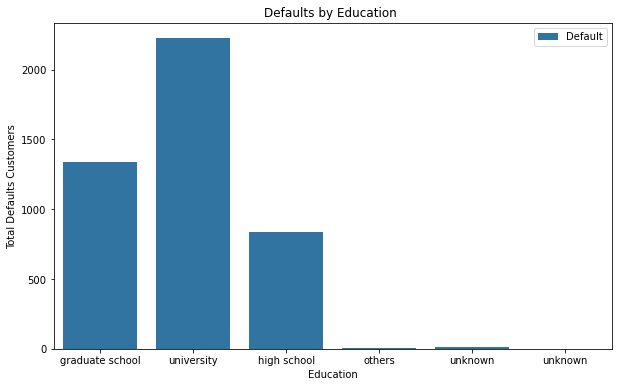

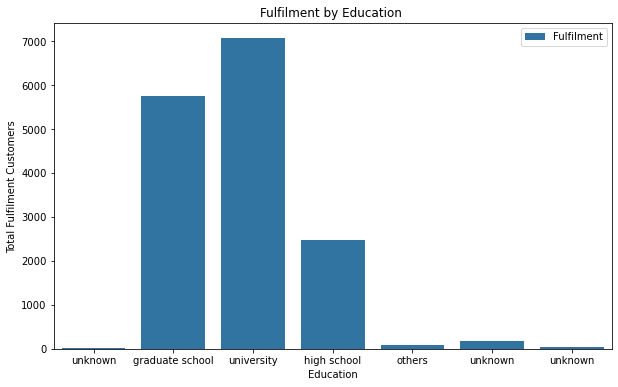

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(
    data = data_train_CustSerTar[data_train_CustSerTar['DEFAULT_JULY'] == 1],
    x = 'EDUCATION',
    hue = 'DEFAULT_JULY',
    #color='steelblue',
).set(title='Defaults by Education ', 
      ylabel = 'Total Defaults Customers', 
      xlabel = 'Education', 
      xticklabels = ['graduate school', 'university', 'high school', 'others', 'unknown', 'unknown'])
plt.legend(labels=['Default'])

plt.figure(figsize=(10,6))
sns.countplot(
    data = data_train_CustSerTar[data_train_CustSerTar['DEFAULT_JULY'] == 0],
    x = 'EDUCATION',
    hue = 'DEFAULT_JULY',
    #color='steelblue',
).set(title='Fulfilment by Education ', 
      ylabel = 'Total Fulfilment Customers', 
      xlabel = 'Education', 
      xticklabels = ['unknown', 'graduate school', 'university', 'high school', 'others', 'unknown', 'unknown'])
plt.legend(labels=['Fulfilment'])

**Comment**

Based on the previous bar plots it can be concluded that the most defualts come from the people with a university degree. Now comparing the first plot to the second, which gives the context, shows that the people with a university compose most of the clients. The following step should be to compare the proportions of each category to actually determine which education level usually defualts the most. 

### **Question 2**

(0.5 points)

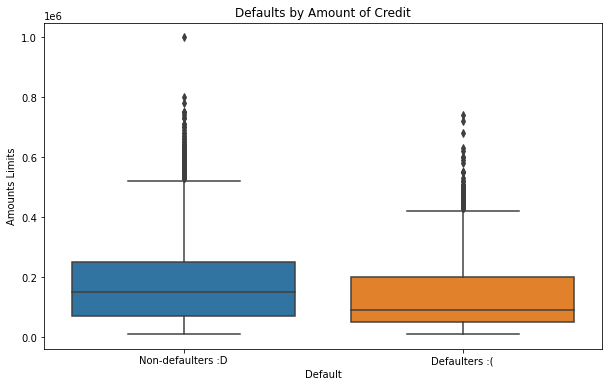

In [25]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data = data_train_CustSerTar,
    x = 'DEFAULT_JULY',
    y = 'LIMIT_BAL'
).set(
    title='Defaults by Amount of Credit', 
    xlabel='Default', 
    ylabel='Amounts Limits',
    xticklabels = ['Non-defaulters :D', 'Defaulters :('])

**Comment**

Based on the boxplot it shows that the Amount of credit isn't a clear differiante factor to undesrstand the clietns who defual. In this case the mean can considerded close. What it draws attetion is the smaller range of the boxplot of defaults. In this cases the customers who default with a credit limit over 500K seems to be an outlier. 

### **Question 3**

(1 point)

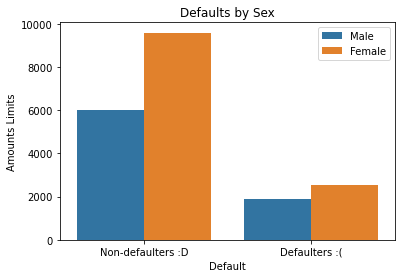

In [26]:
sns.countplot(
    data = data_train_CustSerTar,
    x = 'DEFAULT_JULY',
    hue = 'SEX'
).set(
    title='Defaults by Sex', 
    xlabel='Default', 
    ylabel='Amounts Limits',
    xticklabels = ['Non-defaulters :D', 'Defaulters :('])

plt.legend(labels=['Male', 'Female'])

**Comment**

On previous experinces a variable to consider is if either a man or a woman request the loan. In this case it shows that woman usually default more, but it seems through the graph that the male clients are the ones in proportion that default the most. So if a woman request request a loan it's more probable that it would repay the debt. 

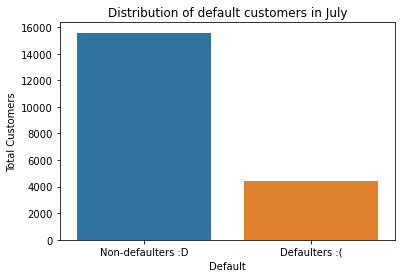

In [27]:
ax = sns.countplot(
    data = data_train_CustSerTar,
    x = 'DEFAULT_JULY'
).set(
    title='Distribution of default customers in July', 
    xlabel='Default', 
    ylabel='Total Customers',
    xticklabels = ['Non-defaulters :D', 'Defaulters :('])

**Comment**

Now one of the first that we need to understand form the data set is the amount of defaults that we are going to get. For the pourpose of this project it shows an imblance set, as expected. In this case the amount of defaulters can be considered relative high. Since, almost 25% of the total custmer will default. From a business point of view this has a huge impact as will need to relly on less customer to have the liquidity necessary to keep the business . 

[Text(0.5, 1.0, 'Correlation Between Variables')]

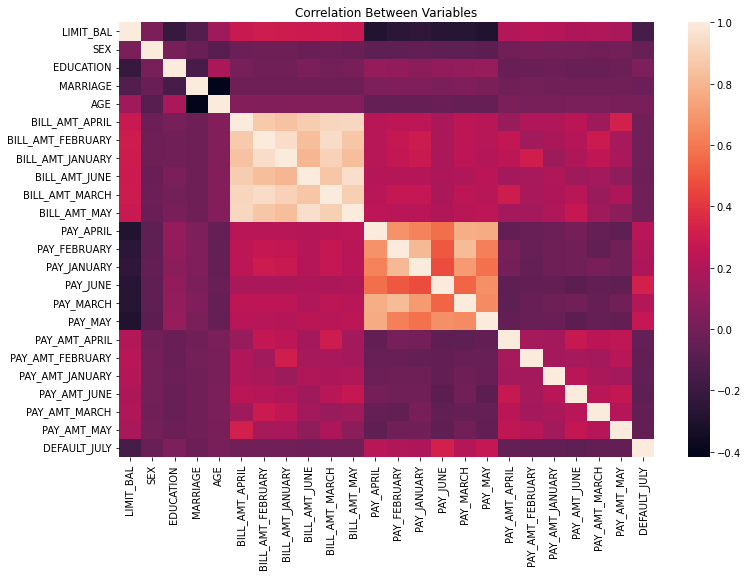

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data_train_CustSerTar.corr()).set( title = 'Correlation Between Variables')

**Comment**

Now regarding the desing of the model, it's interesing to udnerstand if there are variables that cause to default. In this case we don't a clear relationship the target variable. Now that we can observe that there is a clear relation ship between the bill variables and the pay variables. In the desing of the model it can be consider if these variables can be dropped and use the last information insted of the whole information. 

## **C. MACHINE LEARNING (5 points)**

### **Question 1**

(1.5 points)

### Dummy Models

Here we aregoing to create some benchmarks to see how the models perfoms against the untreated dataset.

#### XGBClassifier Model

First we are going to calculate the score for a XGBClassifier Model

In [29]:
X = data_train_CustSerTar.drop('DEFAULT_JULY', axis =1 )
y = data_train_CustSerTar['DEFAULT_JULY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337, stratify= y)

model = xgb.XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

The confusion Matrix is obtained

In [30]:
#Predicting the results
ypred = model.predict(X_test)
cm = confusion_matrix(y_test,ypred) 
print(cm)

#Generating the probabilities
probs = model.predict_proba(X_test)[:,1]
predictions = pd.DataFrame({'defaults':y_test, 'pred':probs})

[[2955  161]
 [ 569  315]]


The AUC-ROC score is obtained

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

AUC-ROC: 0.7527567176273096


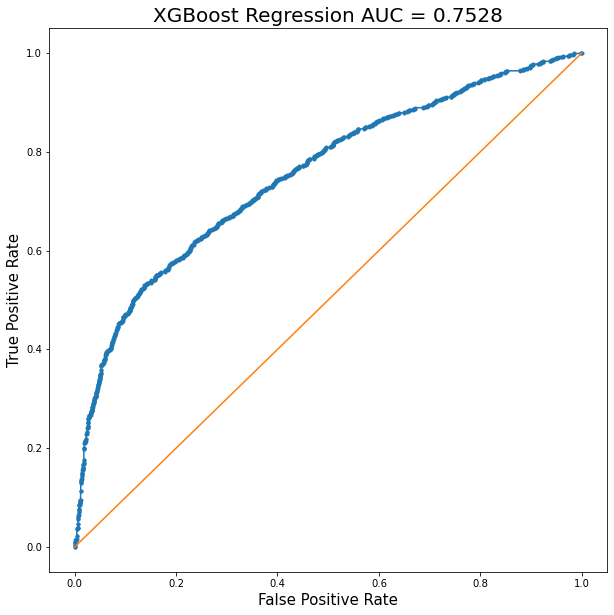

In [31]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, marker = ".")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
# axis labels
plt.title('XGBoost Regression AUC = {0:.4f}'.format(roc_auc_score(predictions.defaults, predictions.pred)), fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# show the plot
plt.show()

#### Logistic Regression Model

Now we are going to calculate the score for a Logistic Regression Model

In [32]:
X = data_train_CustSerTar.drop('DEFAULT_JULY', axis =1 )
y = data_train_CustSerTar['DEFAULT_JULY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337, stratify= y)

logreg = LogisticRegression(random_state=1337, max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)


The confusion Matrix is obtained

In [33]:
#Predicting the results
ypred = logreg.predict(X_test)
cm = confusion_matrix(y_test,ypred) 
print(cm)

#Generating the probabilities
probs = logreg.predict_proba(X_test)[:,1]
predictions = pd.DataFrame({'defaults':y_test, 'pred':probs})

[[3116    0]
 [ 884    0]]


The AUC-ROC score is obtained

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

AUC-ROC: 0.6502807724254903


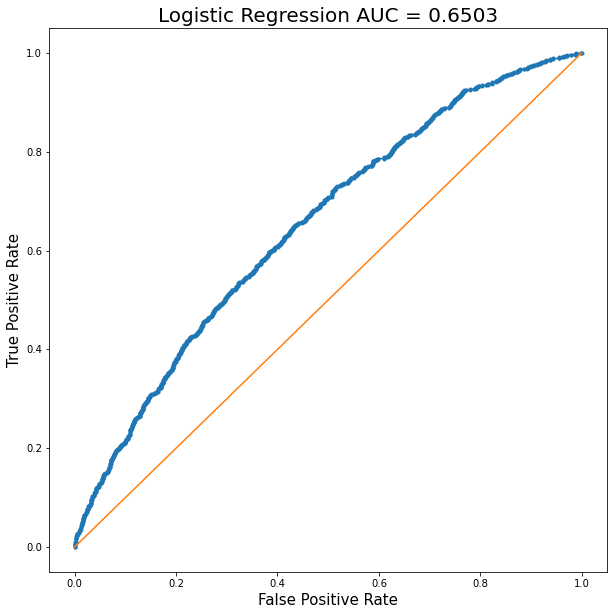

In [35]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, marker = ".")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
# axis labels
plt.title('Logistic Regression AUC = {0:.4f}'.format(roc_auc_score(predictions.defaults, predictions.pred)), fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# show the plot
plt.show()

#### Random Forest Model

Now we are going to calculate the score for a Random Forest Model

In [36]:
X = data_train_CustSerTar.drop('DEFAULT_JULY', axis =1 )
y = data_train_CustSerTar['DEFAULT_JULY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337, stratify= y)

clf = RandomForestClassifier(max_depth=10, random_state=1337)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=1337)

The confusion Matrix is obtained

In [37]:
#Predicting the results
ypred = clf.predict(X_test)
cm = confusion_matrix(y_test,ypred) 
print(cm)

#Generating the probabilities
probs = clf.predict_proba(X_test)[:,1]
predictions = pd.DataFrame({'defaults':y_test, 'pred':probs})

[[2986  130]
 [ 569  315]]


The AUC-ROC score is obtained

In [38]:
fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

AUC-ROC: 0.7766742880128253


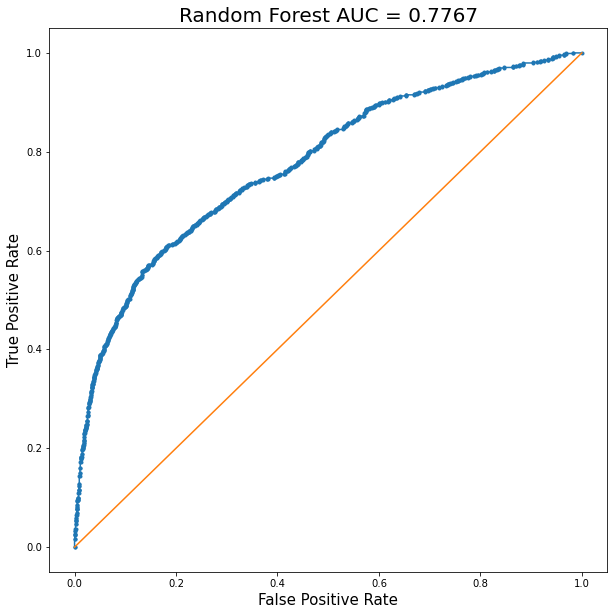

In [39]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, marker = ".")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
# axis labels
plt.title('Random Forest AUC = {0:.4f}'.format(roc_auc_score(predictions.defaults, predictions.pred)), fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# show the plot
plt.show()

### Preprocessing the data

#### Feautrue Engineering

The variabe **L3PB** is created. This variable sums the last three bills plus the last three payments to check if the customer was able to fullfil its obligations. 

In [40]:
Bills = ['BILL_AMT_MARCH', 'BILL_AMT_APRIL', 'BILL_AMT_MAY']
Payments = ['PAY_AMT_JUNE', 'PAY_AMT_APRIL', 'PAY_AMT_MAY']

data_train_CustSerTar['L3PB'] = data_train_CustSerTar[Payments].sum(axis = 1) - data_train_CustSerTar[Bills].sum(axis = 1)

An adjustment is realizaed to the EDUCATION variable since it included a previously unknow variable.

In [41]:
data_train_CustSerTar['EDUCATION'].mask(data_train_CustSerTar['EDUCATION'] == 0, 5, inplace=True)

In [42]:
data_train_CustSerTar['EDUCATION'].unique()

array([2, 3, 1, 4, 6, 5], dtype=int64)

Creating a new dictionary to later use it as part of the one hot encoding

In [43]:
edu = {1: 'graduate school', 
       2: 'university', 
       3: 'high school', 
       4: 'others', 
       5: 'unknown', 
       6: 'unknown'}

marriage = {1: 'married', 
            2: 'single', 
            3: 'others'}

sex = {1: 'male', 
       2: 'female'}

Applying the dicitonary to the respective variables

In [44]:
data_train_CustSerTar['EDUCATION'] = data_train_CustSerTar['EDUCATION'].map(edu)
data_train_CustSerTar['MARRIAGE'] = data_train_CustSerTar['MARRIAGE'].map(marriage)
data_train_CustSerTar['SEX'] = data_train_CustSerTar['SEX'].map(sex)

Defining the variables that are going to be dropped. This was taken into account since the correlation matrix showed that these variables brought almost the same information between them. Also, the ifnoramtion contained in these variables is incldued in the L3PB variable.

In [45]:
Bills = ['BILL_AMT_MARCH', 'BILL_AMT_FEBRUARY', 'BILL_AMT_JANUARY']
Payments = ['PAY_AMT_JANUARY', 'PAY_AMT_FEBRUARY', 'PAY_AMT_MARCH']
Pay = ['PAY_JANUARY', 'PAY_FEBRUARY', 'PAY_MARCH', 'PAY_APRIL', 'PAY_MAY']

In [46]:
train_data = data_train_CustSerTar.drop(Bills, axis = 1)
train_data = train_data.drop(Payments, axis = 1)
train_data = train_data.drop(Pay, axis = 1)

In [47]:
train_data

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,BILL_AMT_APRIL,BILL_AMT_JUNE,BILL_AMT_MAY,PAY_JUNE,PAY_AMT_APRIL,PAY_AMT_JUNE,PAY_AMT_MAY,DEFAULT_JULY,L3PB
ID,,,,,,,,,,,,,,
9910,130000.0,female,university,married,27,81231.0,76885.0,79106.0,0.0,3000.0,3500.0,4000.0,0,-231820.0
15561,60000.0,female,high school,married,48,8422.0,4823.0,5471.0,-1.0,4377.0,5491.0,9683.0,1,1281.0
23607,330000.0,female,graduate school,single,44,253863.0,243621.0,259517.0,0.0,9400.0,21400.0,0.0,1,-740115.0
6314,60000.0,female,university,single,24,15069.0,29832.0,18628.0,0.0,1000.0,1538.0,1308.0,0,-45612.0
27534,180000.0,female,graduate school,single,33,178.0,4500.0,2580.0,-2.0,1500.0,2580.0,178.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,330000.0,female,graduate school,single,33,-200.0,-200.0,-200.0,1.0,350.0,0.0,0.0,0,600.0
17730,50000.0,male,university,single,49,48551.0,59236.0,53689.0,0.0,2047.0,2000.0,2124.0,1,-130725.0
28030,410000.0,male,graduate school,single,32,7764.0,3339.0,13047.0,-1.0,623.0,10000.0,7764.0,0,-3047.0


#### Train Test Split - Transforming Columns

Creatinig a validation set for the model to be later evaluated

In [48]:
X = train_data.drop('DEFAULT_JULY', axis =1 )
y = train_data['DEFAULT_JULY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337, stratify= y)

# One Hot Encoding X_train
ohe = OneHotEncoder(sparse= False)
cat_feat = X_train.select_dtypes("O").columns
cat_train_data = ohe.fit_transform(X_train[cat_feat])
cat_train_data = pd.DataFrame(cat_train_data)

#Standard Scaling X_train
scl = StandardScaler()
num_feat = X_train.select_dtypes("float64").columns
num_train_data = scl.fit_transform(X_train[num_feat])
num_train_data = pd.DataFrame(num_train_data, columns= num_feat)

# Creating new X_train

X_train = X_train.drop(cat_feat, axis =1)
X_train = X_train.drop(num_feat, axis =1)
X_train = X_train.reset_index()

X_train = pd.concat([X_train, cat_train_data], axis=1)
X_train = pd.concat([X_train, num_train_data], axis=1)

X_train = X_train.set_index('ID')

# One Hot Encoding X_test
cat_test_data = ohe.transform(X_test[cat_feat])
cat_test_data = pd.DataFrame(cat_test_data)

# Standard Scaling X_test
num_test_data = scl.transform(X_test[num_feat])
num_test_data = pd.DataFrame(num_test_data, columns= num_feat)

#Creating the X_test
X_test = X_test.drop(cat_feat, axis =1)
X_test = X_test.drop(num_feat, axis =1)
X_test = X_test.reset_index()

X_test = pd.concat([X_test, cat_test_data], axis=1)
X_test = pd.concat([X_test, num_test_data], axis=1)

X_test = X_test.set_index('ID')

#### XGBClassifier - Model

Evaluating the model with a random gridsearch.

In [49]:
model = xgb.XGBClassifier(objective='binary:logistic', random_state = 1337)

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1337)

parameters = {
        'learning_rate': [0.01,0.1,0.5,0.75,1,2],
        'n_estimators': [1,5,10,15,20,25,30,40],
        'min_child_weight': [1,2,3,4,5,6,7,8,9,10],
        'gamma': [0,25, 0.5, 0.75, 1, 1.25,1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6,7,8,9,10]
        }

search_xgb = RandomizedSearchCV(
    model,                               # this is the instantiated estimator object, that is, the model we want to tune
    param_distributions = parameters,    # this is the predefinad search space
    scoring = 'roc_auc',                  # the metric we want the tuner calculates in order to select the best combination
    cv = skf.get_n_splits(X_train, y_train),                              # the cross-validation schema we want to use (same as in the "cross_validate" or "cross_val_score")
    refit = True,                        # if we want to fit again the model on the best hyp. setting found after the process
    n_jobs = -1,                         # this is to indicate the operative system to use all processor cores and speed up the process,
    return_train_score=True,           # is we want the tuner also return the scores on training (not just in validation)
    n_iter = 3000                         # the number of attempts we want to perform
)

In [50]:
search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           predictor=None, random_state=1337, ...),
           

In [51]:
search_xgb.best_params_

{'subsample': 0.6,
 'n_estimators': 40,
 'min_child_weight': 8,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 5,
 'colsample_bytree': 0.6}

In [52]:
#Predicting the results
ypred = search_xgb.predict(X_test)
cm = confusion_matrix(y_test,ypred) 
print(cm)

#Generating the probabilities
probs = search_xgb.predict_proba(X_test)[:,1]
predictions = pd.DataFrame({'defaults':y_test, 'pred':probs})

fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

[[2996  120]
 [ 573  311]]
AUC-ROC: 0.7759140895915985


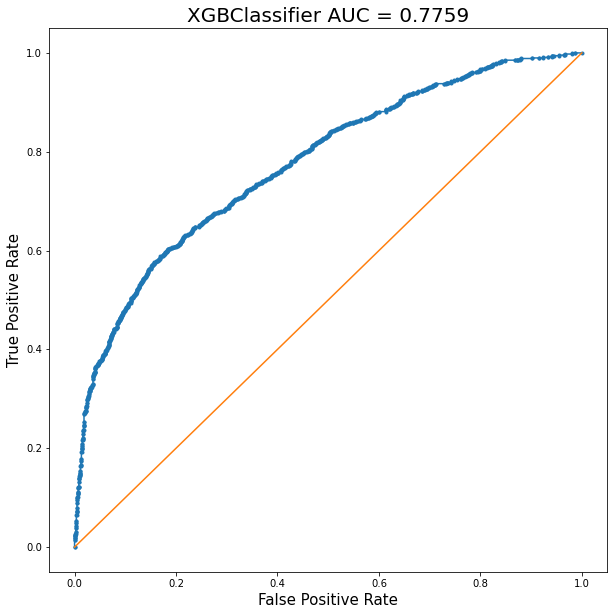

In [53]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, marker = ".")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
# axis labels
plt.title('XGBClassifier AUC = {0:.4f}'.format(roc_auc_score(predictions.defaults, predictions.pred)), fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# show the plot
plt.show()

#### Logistic Regression - Model

Evaluating the model with a random gridsearch.

In [54]:
logreg = LogisticRegression(random_state= 11337, max_iter= 1000)

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1337)

parameters = {
    'C': np.logspace(-4, 4, 100),
    'penalty': ['l1', 'l2']
}

search_lgr = RandomizedSearchCV(
    logreg,                               # this is the instantiated estimator object, that is, the model we want to tune
    param_distributions = parameters,    # this is the predefinad search space
    scoring = 'roc_auc',                  # the metric we want the tuner calculates in order to select the best combination
    cv = skf.get_n_splits(X_train, y_train),                              # the cross-validation schema we want to use (same as in the "cross_validate" or "cross_val_score")
    refit = True,                        # if we want to fit again the model on the best hyp. setting found after the process
    n_jobs = -1,                         # this is to indicate the operative system to use all processor cores and speed up the process,
    return_train_score=True,           # is we want the tuner also return the scores on training (not just in validation)
    n_iter=100                         # the number of attempts we want to perform
)

In [55]:
search_lgr.fit(X_train, y_train)

C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
235 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
235 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
V

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000,
                                                random_state=11337),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03,...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                                        'penalty': ['l1', 'l2']},
                   return_train_score=True, scoring='roc_auc')

In [56]:
search_lgr.best_params_

{'penalty': 'l2', 'C': 0.6280291441834259}

In [57]:
#Predicting the results
ypred = search_lgr.predict(X_test)
cm = confusion_matrix(y_test,ypred) 
print(cm)

#Generating the probabilities
probs = search_lgr.predict_proba(X_test)[:,1]
predictions = pd.DataFrame({'defaults':y_test, 'pred':probs})

fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

[[3040   76]
 [ 673  211]]
AUC-ROC: 0.7275893941066107


C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


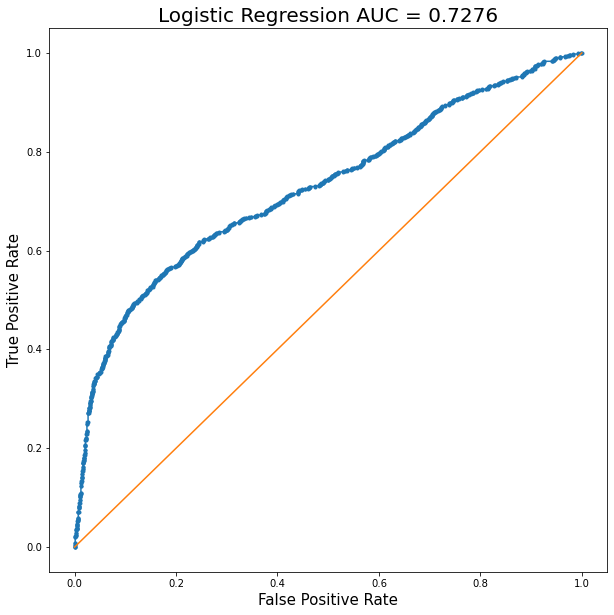

In [58]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, marker = ".")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
# axis labels
plt.title('Logistic Regression AUC = {0:.4f}'.format(roc_auc_score(predictions.defaults, predictions.pred)), fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# show the plot
plt.show()

#### Random Forest - Model

Evaluating the model with a random gridsearch.

In [59]:
clf = RandomForestClassifier(random_state=1337)

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1337)

parameters = {
    'n_estimators': [int(x) for x in np.linspace(start = 1, stop = 500, num = 250)],
    'min_samples_leaf': [20,25,30],
    'min_samples_split': [40, 50, 60],
    'max_depth': [int(x) for x in np.linspace(1, 30, num = 15)]
}

search_clf = RandomizedSearchCV(
    clf,                                     # this is the instantiated estimator object, that is, the model we want to tune
    param_distributions = parameters,        # this is the predefinad search space
    scoring = 'roc_auc',                     # the metric we want the tuner calculates in order to select the best combination
    cv = skf.get_n_splits(X_train, y_train), # the cross-validation schema we want to use (same as in the "cross_validate" or "cross_val_score")
    refit = True,                            # if we want to fit again the model on the best hyp. setting found after the process
    n_jobs = -1,                             # this is to indicate the operative system to use all processor cores and speed up the process,
    return_train_score=True,                 # is we want the tuner also return the scores on training (not just in validation)
    n_iter = 1000                            # the number of attempts we want to perform
)

In [60]:
search_clf.fit(X_train, y_train)

C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1337),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19, 21, 23, 25, 27,
                                                      30],
                                        'min_samples_leaf': [20, 25, 30],
                                        'min_samples_split': [40, 50, 60],
                                        'n_estimators': [1, 3, 5, 7, 9, 11, 13,
                                                         15, 17, 19, 21, 23, 25,
                                                         27, 29, 31, 33, 35, 37,
                                                         39, 41, 43, 45, 47, 49,
                                                         51, 53, 55, 57, 59, ...]},
                   return_train_score=True, scoring='roc_auc')

In [61]:
search_clf.best_params_

{'n_estimators': 293,
 'min_samples_split': 50,
 'min_samples_leaf': 20,
 'max_depth': 15}

In [62]:
#Predicting the results
ypred = search_clf.predict(X_test)
cm = confusion_matrix(y_test,ypred) 
print(cm)

#Generating the probabilities
probs = search_clf.predict_proba(X_test)[:,1]
predictions = pd.DataFrame({'defaults':y_test, 'pred':probs})

fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


[[2999  117]
 [ 584  300]]
AUC-ROC: 0.7798597517411232


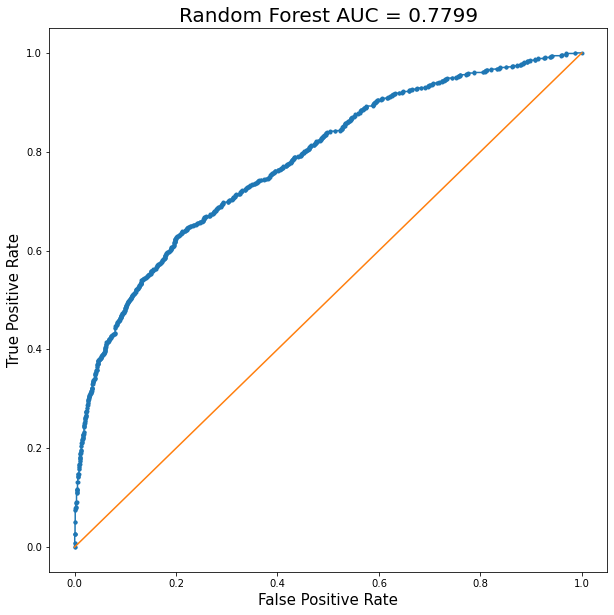

In [63]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, marker = ".")
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), label="diagonal")
# axis labels
plt.title('Random Forest AUC = {0:.4f}'.format(roc_auc_score(predictions.defaults, predictions.pred)), fontsize = 20)
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
# show the plot
plt.show()

#### Preparing Test Data Set 

Preprarign the dataset that would function as the test dataset.

In [64]:
#Reading the test_data file
test_data = pd.read_csv('data/test_data.csv')

In [65]:
#Applying transformations prevoiusly done to the train dataset
test_data['L3PB'] = test_data[Payments].sum(axis = 1) - test_data[Bills].sum(axis = 1)
test_data['EDUCATION'].mask(test_data['EDUCATION'] == 0, 5, inplace=True)
test_data['EDUCATION'] = test_data['EDUCATION'].map(edu)
test_data['MARRIAGE'] = test_data['MARRIAGE'].map(marriage)
test_data['SEX'] = test_data['SEX'].map(sex)
test_data = test_data.drop(Bills, axis = 1)
test_data = test_data.drop(Payments, axis = 1)
test_data = test_data.drop(Pay, axis = 1)
test_data = test_data.set_index('ID')

In [66]:
#Reviewing the results
test_data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_JUNE,BILL_AMT_JUNE,BILL_AMT_MAY,BILL_AMT_APRIL,PAY_AMT_JUNE,PAY_AMT_MAY,PAY_AMT_APRIL,DEFAULT_JULY,L3PB
ID,,,,,,,,,,,,,,
11316,170000.0,male,university,single,36,-2,600.0,1598.0,0.0,1598.0,0.0,1340.0,0,1860.0
26420,120000.0,male,university,single,25,0,11147.0,9757.0,9423.0,2446.0,438.0,1000.0,0,-8787.0
7847,250000.0,female,graduate school,single,38,-1,14766.0,990.0,8150.0,990.0,8150.0,15410.0,0,-15410.0
8083,100000.0,male,graduate school,married,55,0,10712.0,18135.0,31498.0,8000.0,2000.0,4000.0,0,-48084.0
7455,30000.0,male,graduate school,single,56,2,27033.0,27772.0,28740.0,1480.0,1448.0,1021.0,0,-83722.0


In [67]:
#Obtaning explanatory and target values
X_test_data = test_data.drop('DEFAULT_JULY', axis =1 )
y_test_data = test_data['DEFAULT_JULY']

# One Hot Encoding X_test
cat_test_data = ohe.transform(X_test_data[cat_feat])
cat_test_data = pd.DataFrame(cat_test_data)

# Standard Scaling X_test
num_test_data = scl.transform(X_test_data[num_feat])
num_test_data = pd.DataFrame(num_test_data, columns= num_feat)

#Creating the X_test
X_test_data = X_test_data.drop(cat_feat, axis =1)
X_test_data = X_test_data.drop(num_feat, axis =1)
X_test_data = X_test_data.reset_index()

X_test_data = pd.concat([X_test_data, cat_test_data], axis=1)
X_test_data = pd.concat([X_test_data, num_test_data], axis=1)

X_test_data = X_test_data.set_index('ID')

#### XGBClassifier 

Evaluating the best model against the test dataset

In [68]:
#Predicting the results
ypred = search_xgb.predict(X_test_data)
cm = confusion_matrix(y_test_data,ypred) 
print(cm)

#Generating the probabilities
probs = search_xgb.predict_proba(X_test_data)[:,1]
predictions = pd.DataFrame({'defaults':y_test_data, 'pred':probs})

fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

[[6696  309]
 [1313  682]]
AUC-ROC: 0.776803643655892


#### Logistic Regression

Evaluating the best model against the test dataset

In [69]:
ypred = search_lgr.predict(X_test_data)
cm = confusion_matrix(y_test_data,ypred) 
print(cm)

probs = search_lgr.predict_proba(X_test_data)[:,1]
predictions = pd.DataFrame({'defaults':y_test_data, 'pred':probs})

fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

[[6824  181]
 [1533  462]]
AUC-ROC: 0.7256355378095488


C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


#### Random Forest 

Evaluating the best model against the test dataset

In [70]:
ypred = search_clf.predict(X_test_data)
cm = confusion_matrix(y_test_data,ypred) 
print(cm)

probs = search_clf.predict_proba(X_test_data)[:,1]
predictions = pd.DataFrame({'defaults':y_test_data, 'pred':probs})

fpr, tpr, thresholds = roc_curve(predictions.defaults, predictions.pred)

# Evaluate peformance through AUC-ROC
socre_auc = roc_auc_score(predictions.defaults, predictions.pred)
print('AUC-ROC:', socre_auc)

C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


[[6711  294]
 [1332  663]]


C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


AUC-ROC: 0.7768354862888843


The best resulting model from all it was the Random Forest. This model would be used to predict the submission dataset.

#### Final Predictions 

Preparing the submission dataset

In [71]:
#Reading the submission_data file
submission_data = pd.read_csv('data/submission_features.csv')

#Applying transformations prevoiusly done to the train dataset
submission_data['L3PB'] = submission_data[Payments].sum(axis = 1) - submission_data[Bills].sum(axis = 1)
submission_data['EDUCATION'].mask(submission_data['EDUCATION'] == 0, 5, inplace=True)
submission_data['EDUCATION'] = submission_data['EDUCATION'].map(edu)
submission_data['MARRIAGE'] = submission_data['MARRIAGE'].map(marriage)
submission_data['SEX'] = submission_data['SEX'].map(sex)
submission_data = submission_data.drop(Bills, axis = 1)
submission_data = submission_data.drop(Payments, axis = 1)
submission_data = submission_data.drop(Pay, axis = 1)
submission_data = submission_data.set_index('ID')

#Obtaning explanatory and target values
X_submission_data = submission_data

# One Hot Encoding X_test
cat_submission_data = ohe.transform(X_submission_data[cat_feat])
cat_submission_data = pd.DataFrame(cat_submission_data)

# Standard Scaling X_test
num_submission_data = scl.transform(X_submission_data[num_feat])
num_submission_data = pd.DataFrame(num_submission_data, columns= num_feat)

#Creating the X_test
X_submission_data = X_submission_data.drop(cat_feat, axis =1)
X_submission_data = X_submission_data.drop(num_feat, axis =1)
X_submission_data = X_submission_data.reset_index()

X_submission_data = pd.concat([X_submission_data, cat_submission_data], axis=1)
X_submission_data = pd.concat([X_submission_data, num_submission_data], axis=1)

X_submission_data = X_submission_data.set_index('ID')

Predicting the probabilities of the submission dataset.

In [72]:
submisssion_predictions = search_clf.predict_proba(X_submission_data)

C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [73]:
submisssion_predictions = pd.DataFrame(submisssion_predictions)

In [74]:
C1_submission = pd.read_csv('data/submission_features.csv')

In [75]:
C1_submission = pd.merge(C1_submission, submisssion_predictions[1], left_index=True, right_index=True)

In [76]:
C1_submission = C1_submission.rename(columns={1: "probabilities"})

Exporting the probabilities obtained.

In [77]:
C1_submission[['ID','probabilities']].to_csv("HerreraPaulino_C1_submission.csv",index=False)

### **Question 2**

(1 point)

In [78]:
C1_submission[['ID','probabilities']].sort_values(by=['probabilities']).head(5)

,ID,probabilities
862,488,0.021008
269,16242,0.027880
914,26872,0.027945
472,5428,0.028885
792,20297,0.029875


### **Question 3**

(2.5 points)

Now the bank wants to optimize the decision-making process by establishing the optimal threshold for the model in order to effectively take the decision about when to issue the credit and when not. So, taking into account the following numbers:

- A customer who receives a loan but doesn't repay costs 5000 to the bank
- A customer who receives a loan and repays, make a profit of 1000 to the bank
- If the credit is not issued, then there is no profit or loss

Obtaning the probabilties of the randiom model on the est data set, which will be the one to evalutethe best threshold.

In [79]:
probabilities = pd.DataFrame(search_clf.predict_proba(X_test_data))

C:\Users\Pulin\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [80]:
probabilities = probabilities.rename(columns={1: "probabilities"})

In [81]:
probabilities = probabilities['probabilities']

In [82]:
y_test_data = y_test_data.reset_index()

In [83]:
probabilities = pd.merge(y_test_data['DEFAULT_JULY'], probabilities, left_index=True, right_index=True)

Through a loop it's evaluated the different considerated thresholds. Note that in this case a limited range has been settle from previous attempts. Note: also a lambda function can be implemented to obtain the same results.

In [84]:
results = {}
for prob in range(18750, 19130):
    profits = 0
    threshold = prob/100000
    for ind in probabilities.index:
        if  probabilities.loc[ind, 'probabilities'] <= threshold and probabilities.loc[ind, 'DEFAULT_JULY'] == 0:
            profits += 1000
        elif probabilities.loc[ind, 'probabilities'] <= threshold and probabilities.loc[ind, 'DEFAULT_JULY'] == 1:
            profits += -5000
        else:
            profits += 0
    results[threshold] = [profits]

Sorting the results to obtain the best threshold

In [85]:
sort_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

In [86]:
print(f'The best result obtained is through a threshold of {sort_results[0][0]}')

The best result obtained is through a threshold of 0.19052


In [87]:
sort_results

[(0.19052, [1969000]),
 (0.19053, [1969000]),
 (0.19054, [1969000]),
 (0.19055, [1969000]),
 (0.1905, [1968000]),
 (0.19051, [1968000]),
 (0.19044, [1967000]),
 (0.19045, [1967000]),
 (0.19046, [1967000]),
 (0.19047, [1967000]),
 (0.19048, [1967000]),
 (0.19049, [1967000]),
 (0.19043, [1966000]),
 (0.19038, [1965000]),
 (0.19039, [1965000]),
 (0.1904, [1965000]),
 (0.19041, [1965000]),
 (0.19042, [1965000]),
 (0.19033, [1964000]),
 (0.19034, [1964000]),
 (0.19035, [1964000]),
 (0.19036, [1964000]),
 (0.19037, [1964000]),
 (0.19056, [1964000]),
 (0.19057, [1964000]),
 (0.19058, [1964000]),
 (0.19028, [1963000]),
 (0.19029, [1963000]),
 (0.1903, [1963000]),
 (0.19031, [1963000]),
 (0.19032, [1963000]),
 (0.1912, [1963000]),
 (0.19023, [1962000]),
 (0.19024, [1962000]),
 (0.19025, [1962000]),
 (0.19026, [1962000]),
 (0.19027, [1962000]),
 (0.19015, [1961000]),
 (0.19016, [1961000]),
 (0.19017, [1961000]),
 (0.19018, [1961000]),
 (0.19019, [1961000]),
 (0.1902, [1961000]),
 (0.19021, [1961